In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

In [8]:
def load_data(file_path, selected_features=None):
    # Read the CSV file
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Compute features for each stock symbol
    symbol_dfs = []
    for symbol, symbol_df in df.groupby('Symbol'):
        # Compute returns and other features
        symbol_df['return'] = symbol_df['Close'].pct_change()
        
        # Rolling standard deviation of returns
        symbol_df['return_std_5'] = symbol_df['return'].rolling(window=5).std()
        symbol_df['return_std_10'] = symbol_df['return'].rolling(window=10).std()
        symbol_df['return_std_20'] = symbol_df['return'].rolling(window=20).std()
        
        # Lag features
        for i in range(1, 11):
            # Price returns
            symbol_df[f'return_lag_{i}'] = symbol_df['return'].shift(i)
            
            # High-Low ratio
            symbol_df[f'hl_ratio_lag_{i}'] = (symbol_df['High'] / symbol_df['Low']).shift(i)
            
            # Close-Open ratio
            symbol_df[f'co_ratio_lag_{i}'] = (symbol_df['Close'] / symbol_df['Open']).shift(i)
            
            # Volume change
            symbol_df[f'volume_change_lag_{i}'] = symbol_df['Volume'].pct_change(i)
        
        symbol_dfs.append(symbol_df)
    
    # Combine all symbol dataframes
    df = pd.concat(symbol_dfs).sort_values('Date')
    
    # Define features
    features = [
        'Close', 'Volume',
        'return_std_5', 'return_std_10', 'return_std_20'
    ]
    
    for i in range(1, 11):
        features.extend([
            f'return_lag_{i}', f'hl_ratio_lag_{i}', 
            f'co_ratio_lag_{i}', f'volume_change_lag_{i}'
        ])

    # Drop rows with NaN values
    df = df.dropna()

    # Apply feature selection if provided
    if selected_features:
        features = [f for f in features if f in selected_features]

    # Prepare data
    data = df[features].values

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Prepare X and y
    X = scaled_data
    y = scaled_data[:, 0]  # Assuming the target column is the first one

    # Time-based train-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, features


In [9]:
file_path = '../data/updated_data.csv'  
target_column = 'Close'
X_train, X_val, X_test, y_train, y_val, y_test, scaler, features = load_data(file_path, target_column)

In [10]:
# Train XGBoost model 
def train_xgb(X_train, y_train, X_val, y_val, 
              n_estimators=300, learning_rate=0.05, max_depth=9, 
              min_child_weight=2, subsample=0.9, colsample_bytree=0.7, gamma=0.1):
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        tree_method='hist', 
        early_stopping_rounds=10  
    )

    # Fit the model with the training data
    model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              verbose=False)
    
    return model

In [11]:
# Evaluate model performance
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)
    
    num_features = scaler.data_min_.shape[0]
    dummy = np.zeros((len(y_pred), num_features))
    dummy[:, 0] = y_pred
    predictions_inversed = scaler.inverse_transform(dummy)[:, 0]
    
    dummy[:, 0] = y_test
    y_test_inversed = scaler.inverse_transform(dummy)[:, 0]
    
    mse = mean_squared_error(y_test_inversed, predictions_inversed)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inversed, predictions_inversed)
    
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return predictions_inversed, y_test_inversed

In [12]:
model = train_xgb(X_train, y_train, X_val, y_val)
predictions, actual = evaluate_model(model, X_test, y_test, scaler)

MSE: 37695.7048, RMSE: 194.1538, MAE: 43.3194


1


<Figure size 1000x800 with 0 Axes>

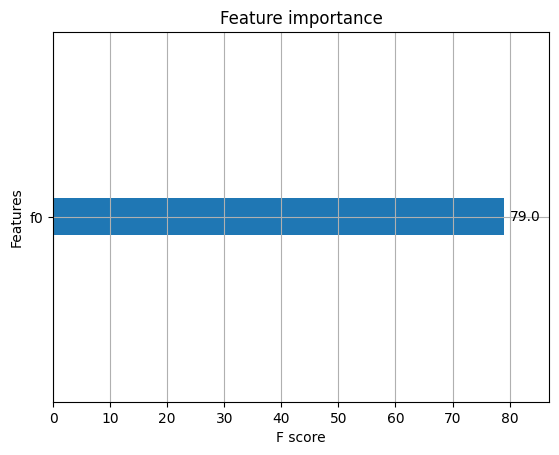

In [26]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20)  # Show only top 20 features
print(X_train.shape[1])
plt.show()

In [27]:
# retrain on top 20 features
param_grid = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [5, 7, 9, 11, 15],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Initialize model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid,
    n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=42,
    scoring='neg_mean_squared_error'
)

random_search.fit(X_train, y_train)

# Get the best model and evaluate on validation set
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)

print("Best parameters found:", random_search.best_params_)
print("Validation Mean Squared Error:", val_mse)

# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Final Test Mean Squared Error:", test_mse)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=700, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, ma

In [43]:
# retrain with best params
model = train_xgb(X_train, y_train, X_val, y_val, 
                  n_estimators=200, learning_rate=0.1, 
                  max_depth=5, min_child_weight=3, 
                  subsample=0.7, colsample_bytree=0.7, gamma=0)

predictions, actual = evaluate_model(model, X_test, y_test, scaler)

MSE: 35104.1585, RMSE: 187.3610, MAE: 37.9597
(10965,)


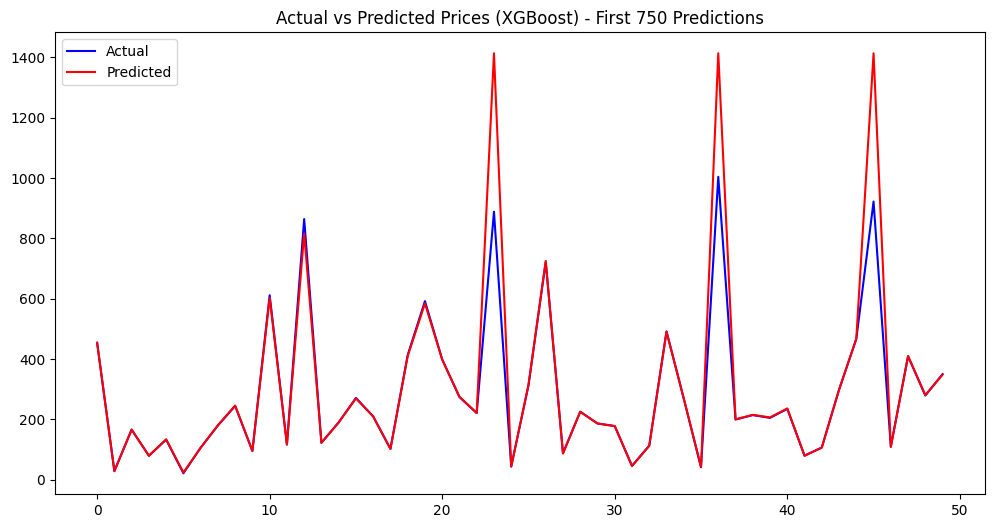

In [ ]:
# Number of points per plot
chunk_size = 125

# Loop to plot every 125 predictions
for i in range(0, len(actual), chunk_size):
    actual_chunk = actual[i:i+chunk_size]
    predictions_chunk = predictions[i:i+chunk_size]

    # Plotting each chunk
    plt.figure(figsize=(12, 6))
    plt.plot(actual_chunk, label='Actual', color='blue')
    plt.plot(predictions_chunk, label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Prices (XGBoost) - Predictions {i+1} to {i+chunk_size}')
    plt.legend()
    plt.show()


In [36]:
# Calculate returns
def calculate_strategy_return(actual_prices, predicted_prices):
    returns = []
    for i in range(1, len(actual_prices)):
        if predicted_prices[i] > actual_prices[i - 1]:  # Buy signal
            returns.append(actual_prices[i] / actual_prices[i - 1] - 1)
        elif predicted_prices[i] < actual_prices[i - 1]:  # Sell signal
            returns.append(-1 * (actual_prices[i] / actual_prices[i - 1] - 1))
        else:
            returns.append(0)  

    strategy_return = sum(returns) * 100  
    return strategy_return

In [35]:
strategy_return = calculate_strategy_return(actual, predictions)
print(f"Strategy Return: {strategy_return:.2f}%")

Strategy Return: 2671637.93%
